In [1]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()

In [2]:
@rf.block
class STDIn:
    filename: str
    records: int
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        with open(project_space_path(self.filename), 'r') as f:
            text_str = f.read()

        logger.info(len(text_str))
        for _ in range(self.records):
            self.out_ds.put(text_str)

            
@rf.block
class ReplaceChar:
    in_ds: rf.SeriesInput[typ.Any]
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        for i in self.in_ds:
            text_str = i.replace('r', '!!!R!!!')
            self.out_ds.put(text_str)
            
            
@rf.block
class PrintReplaceFreq:
    in_ds: rf.SeriesInput[typ.Any]
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        for i in self.in_ds:
            logger.info(i.count('!!!R!!!'))
            self.out_ds.put(i)
            
            
@rf.block
class DeReplaceChar:
    in_ds: rf.SeriesInput[typ.Any]
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        for i in self.in_ds:
            text_str = i.replace('!!!R!!!', 'r')
            self.out_ds.put(text_str)


@rf.block
class STDOut:
    in_ds: rf.SeriesInput[typ.Any]
    out_filename: str

    def run(self):
        text_str = ''
        for i in self.in_ds:
            if len(text_str) == 0:
                text_str = i
            else:
                continue
        logger.info(len(text_str))
        sftp_c = datasources('test_source').client()
        with open(project_space_path(self.out_filename), 'w') as f:
            f.write(text_str)
            

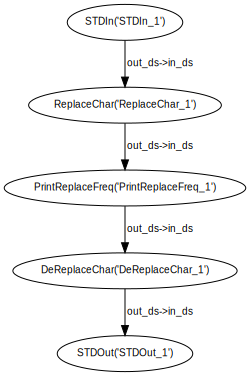

In [3]:
config = {'cores': 1, 'ram': 4096}
records = 1000
size = '1KB'
ip_filename = "/data/sdk_testbench/input_data/file" + size + ".txt"
op_filename = "/data/sdk_testbench/output_data/tc_25.txt"

std_in = STDIn(records=records, filename=ip_filename)
std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
std_in.out_ds = rf.Output.set(transport=rf.FileTransport)

rep_char = ReplaceChar(in_ds=std_in.out_ds)
rep_char.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
rep_char.out_ds = rf.Output.set(transport=rf.FileTransport)

print_rep_freq = PrintReplaceFreq(in_ds=rep_char.out_ds)
print_rep_freq.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
print_rep_freq.out_ds = rf.Output.set(transport=rf.FileTransport)

derep_char = DeReplaceChar(in_ds=print_rep_freq.out_ds)
derep_char.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
derep_char.out_ds = rf.Output.set(transport=rf.FileTransport)

stdout = STDOut(in_ds=derep_char.out_ds, out_filename=op_filename)
stdout.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='file_series_parallel', targets=[stdout])
pipeline.show()

In [4]:
def create_pipeline():
    return pipeline

In [5]:
prun = razor.api.engines('DS-engine').execute(pipeline)